<a href="https://colab.research.google.com/github/Jiyong-Jeon/GAN_study/blob/main/GAN_In_Action/FashionMnist_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Auto-Encoder vs Variational Auto-Encoder
  - latent vector 분포 차이 확인
2. Convalution Variational Auto-Encoder
3. 성능 향상 해보기

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

## Fashion Mnist Dataset

In [ ]:
class_list = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankel boot']

batch_size = 64

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])
                                # transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, generator=torch.Generator(device=device))

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0, generator=torch.Generator(device=device))

100%|██████████| 26421880/26421880 [00:02<00:00, 9851678.81it/s] 


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 175569.68it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3233297.00it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17177626.88it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [ ]:
def imshow(image, label):
    plt.title("label = "+ class_list[label])
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image, interpolation='none', cmap='Blues')

torch.Size([64, 1, 28, 28]) torch.Size([64])


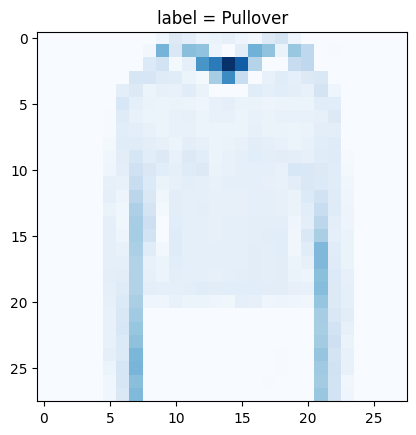

In [ ]:
image, label = next(iter(trainloader))
print(image.shape, label.shape)
imshow(image[0,:], label[0])

# 1. Auto-Encoder vs Variational Auto-Encoder

In [ ]:
# 주요 공통 변수
original_dim = 784    # MNIST 이미지의 높이 x 너비
latent_dim = 2
hidden_dim_1 = 256
hidden_dim_2 = 64
epochs = 50           # 애폭 수

## VAE

### VAE model

In [ ]:
class VAE_Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(original_dim, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.ReLU(),
        )
        self.mean_dc = nn.Linear(hidden_dim_2, latent_dim)
        self.logvar_dc = nn.Linear(hidden_dim_2, latent_dim)

    def sampling(self, z_mean, z_logvar):
        z_std = torch.exp(z_logvar / 2)
        eps = torch.randn_like(z_std)
        return z_mean + eps*z_std

    def forward(self, x):
        x = self.encoder(x)
        z_mean = self.mean_dc(x)
        z_logvar = self.logvar_dc(x)
        z = self.sampling(z_mean, z_logvar)
        return z_mean, z_logvar, z


In [ ]:
class VAE_Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, original_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.decoder(z)
        return x


### VAE Train

In [ ]:
# define loss function
def vae_loss_function(recon_x, x, z_mean, z_logvar):
    BCE_loss = nn.functional.binary_cross_entropy(recon_x, x.view(-1, original_dim) , reduction="sum" ) # default = mean
    KL_loss = -0.5 * torch.sum(1 + z_logvar - torch.exp(z_logvar) - z_mean.pow(2))
    return BCE_loss + KL_loss

In [ ]:
def vae_train(epochs, encoder, decoder, trainloader, optimizer):
    encoder.train()
    decoder.train()

    train_loss_list = []
    for epoch in range(epochs):
        temp_train_loss = 0
        for image_data, _ in trainloader:
            image_data = image_data.to(device)
            z_mean, z_logvar, z = encoder(image_data.view(-1, original_dim))
            recon_x = decoder(z)

            loss = vae_loss_function(recon_x, image_data, z_mean, z_logvar)
            temp_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = temp_train_loss / len(trainloader.dataset)
        train_loss_list.append(train_loss)
        print(">>>> epoch: {}/{} || loss: {:.4f}".format(epoch, epochs, train_loss))

    return train_loss_list

In [ ]:
vae_encoder = VAE_Encoder().to(device)
vae_decoder = VAE_Decoder().to(device)
optimizer = torch.optim.Adam(list(vae_encoder.parameters()) + list(vae_decoder.parameters()), lr=0.0001)

In [ ]:
%%time

vae_train_loss= vae_train(epochs, vae_encoder, vae_decoder, trainloader, optimizer)

>>>> epoch: 0/50 || loss: 347.4747
>>>> epoch: 1/50 || loss: 284.5077
>>>> epoch: 2/50 || loss: 279.6204
>>>> epoch: 3/50 || loss: 276.6316
>>>> epoch: 4/50 || loss: 274.1478
>>>> epoch: 5/50 || loss: 272.1599
>>>> epoch: 6/50 || loss: 270.6947
>>>> epoch: 7/50 || loss: 269.6532
>>>> epoch: 8/50 || loss: 268.8703
>>>> epoch: 9/50 || loss: 268.1663
>>>> epoch: 10/50 || loss: 267.5649
>>>> epoch: 11/50 || loss: 266.9820
>>>> epoch: 12/50 || loss: 266.4746
>>>> epoch: 13/50 || loss: 265.9820
>>>> epoch: 14/50 || loss: 265.4665
>>>> epoch: 15/50 || loss: 265.0598
>>>> epoch: 16/50 || loss: 264.6629
>>>> epoch: 17/50 || loss: 264.3104
>>>> epoch: 18/50 || loss: 263.9777
>>>> epoch: 19/50 || loss: 263.6903
>>>> epoch: 20/50 || loss: 263.4334
>>>> epoch: 21/50 || loss: 263.1973
>>>> epoch: 22/50 || loss: 262.9505
>>>> epoch: 23/50 || loss: 262.7600
>>>> epoch: 24/50 || loss: 262.5799
>>>> epoch: 25/50 || loss: 262.4309
>>>> epoch: 26/50 || loss: 262.2301
>>>> epoch: 27/50 || loss: 262.0780
>>

### VAE 결과

In [ ]:
def vae_test(encoder, decoder, testloader):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        image_data, label = next(iter(trainloader))
        image_data = image_data.to(device)
        z_mean, z_logvar, z = encoder(image_data.view(-1, original_dim))
        recon_x = decoder(z)

        loss = loss_function(recon_x, image_data, z_mean, z_logvar)
        print(">>>> test loss: {:.4f}".format(loss / len(image_data)))

        plt.rcParams['figure.figsize'] = (15.0, 8.0)

        image_data = image_data.cpu()
        origin_grid = make_grid(image_data, nrow=int(batch_size**0.5), normalize=True).permute(1,2,0).numpy()
        plt.subplot(1, 2, 1)
        plt.title("original image")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(origin_grid)

        sample_images = recon_x.view(-1, 1, 28, 28).cpu()
        recon_grid = make_grid(sample_images, nrow=int(batch_size**0.5), normalize=True).permute(1,2,0).numpy()
        plt.subplot(1, 2, 2)
        plt.title("reconstruct image")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(recon_grid)
        plt.show()


In [ ]:
vae_test(vae_encoder, vae_decoder, testloader)

NameError: ignored

In [ ]:
def vae_scatter(encoder, decoder, testloader):
    encoder.eval()
    decoder.eval()
    plt.figure(figsize=(6, 6))
    with torch.no_grad():
        for image_data, label in testloader:
            image_data = image_data.to(device)
            z_mean, z_logvar, z = encoder(image_data.view(-1, original_dim))
            z_mean = z_mean.cpu().numpy()
            # z_logvar = z_logvar.cpu().numpy()
            # z = z.cpu().numpy()

            plt.scatter(z_mean[:,0], z_mean[:,1], c=label.cpu(), cmap='viridis')
            # plt.scatter(z_logvar[:,0], z_logvar[:,1], c=label.cpu(), cmap='viridis')
            # plt.scatter(z[:,0], z[:,1], c=label.cpu(), cmap='viridis')


    plt.colorbar()
    plt.show()


In [ ]:
vae_scatter(vae_encoder, vae_decoder, testloader)

## AE

### AE model

In [ ]:
class AE_Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(original_dim, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, latent_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return z


In [ ]:
class AE_Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, original_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.decoder(z)
        return x


### AE train

In [ ]:
# define loss function
def ae_loss_function(recon_x, x):
    BCE_loss = nn.functional.binary_cross_entropy(recon_x, x.view(-1, original_dim) , reduction="sum" ) # default = mean
    return BCE_loss

In [ ]:
def ae_train(epochs, encoder, decoder, trainloader, optimizer):
    encoder.train()
    decoder.train()

    train_loss_list = []
    for epoch in range(epochs):
        temp_train_loss = 0
        for image_data, _ in trainloader:
            image_data = image_data.to(device)
            z = encoder(image_data.view(-1, original_dim))
            recon_x = decoder(z)

            loss = ae_loss_function(recon_x, image_data)
            temp_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = temp_train_loss / len(trainloader.dataset)
        train_loss_list.append(train_loss)
        print(">>>> epoch: {}/{} || loss: {:.4f}".format(epoch, epochs, train_loss))

    return train_loss_list

In [ ]:
ae_encoder = AE_Encoder().to(device)
ae_decoder = AE_Decoder().to(device)
optimizer = torch.optim.Adam(list(ae_encoder.parameters()) + list(ae_decoder.parameters()), lr=0.0001)

In [ ]:
%%time

ae_train_loss= ae_train(epochs, ae_encoder, ae_decoder, trainloader, optimizer)

### AE 결과

In [ ]:
def ae_test(encoder, decoder, testloader):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        image_data, label = next(iter(trainloader))
        image_data = image_data.to(device)
        z = encoder(image_data.view(-1, original_dim))
        recon_x = decoder(z)

        loss = ae_loss_function(recon_x, image_data)
        print(">>>> test loss: {:.4f}".format(loss / len(image_data)))

        plt.rcParams['figure.figsize'] = (15.0, 8.0)

        image_data = image_data.cpu()
        origin_grid = make_grid(image_data, nrow=int(batch_size**0.5), normalize=True).permute(1,2,0).numpy()
        plt.subplot(1, 2, 1)
        plt.title("original image")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(origin_grid)

        sample_images = recon_x.view(-1, 1, 28, 28).cpu()
        recon_grid = make_grid(sample_images, nrow=int(batch_size**0.5), normalize=True).permute(1,2,0).numpy()
        plt.subplot(1, 2, 2)
        plt.title("reconstruct image")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(recon_grid)
        plt.show()


In [ ]:
ae_test(ae_encoder, ae_decoder, testloader)

In [ ]:
def ae_scatter(encoder, decoder, testloader):
    encoder.eval()
    decoder.eval()
    plt.figure(figsize=(6, 6))
    with torch.no_grad():
        for image_data, label in testloader:
            image_data = image_data.to(device)
            z = encoder(image_data.view(-1, original_dim))
            z = z.cpu().numpy()
            # z_logvar = z_logvar.cpu().numpy()
            # z = z.cpu().numpy()

            plt.scatter(z[:,0], z[:,1], c=label.cpu(), cmap='viridis')
            # plt.scatter(z_logvar[:,0], z_logvar[:,1], c=label.cpu(), cmap='viridis')
            # plt.scatter(z[:,0], z[:,1], c=label.cpu(), cmap='viridis')


    plt.colorbar()
    plt.show()


In [ ]:
vae_scatter(vae_encoder, vae_decoder, testloader)

In [ ]:
ae_scatter(ae_encoder, ae_decoder, testloader)